# Data analysis for the project 'Lying about the Pope is a sin?'

I want to ask some questions about the dataset, such as:

1. What words are recurring in the claims?
2. Which languages publish the most fact-checks about the Pope?
3. In which year did we have the most lies checked about the Pope?
4. Who was the target of more lies, Pope Francis or Pope Leo XIV?
5. Which fact-checking agencies have the most publications about the Pope?

In [1]:
import pandas as pd
df = pd.read_excel('factcheck_pope_results.xlsx')

# Criação de Coluna Extra em Inglês

To analyze the most current topics, I need to translate the claims (lies) into a single language.

_Note: In the Google Fact Check API, fact-checking agencies fill the 'claim' field with the lie that is circulating on social media._

In [2]:
from langdetect import detect
from deep_translator import GoogleTranslator
from tqdm import tqdm
tqdm.pandas()

#Creating a function to translate Claim into English.
def translate_to_en(claim):
    try:
        language = detect(claim)
        if language != 'en':
            return GoogleTranslator(source='auto', target='en').translate(claim)
        else:
            return claim
    except Exception as e:
        return f"[Error: {e}]"

#I looked for how to put a progress bar because it was taking a long time to translate and I didn't know if it was working.
df['claim_en'] = df['Claim'].astype(str).progress_apply(translate_to_en)
df.to_excel("claims_traduzidas.xlsx", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 812/812 [01:54<00:00,  7.10it/s]


# Why I use KeyBERT

I tried to do a simple word count, but there were a lot of words that didn't make sense of the claim and just made connections in the sentence. I decided to use KeyBERT because it seems to analyze the meaning of the sentence, highlighting the main keywords.

Here is the KeyBERT documentation: https://maartengr.github.io/KeyBERT/

In [15]:
from keybert import KeyBERT

claims_eng = pd.read_excel("claims_traduzidas.xlsx")
kw_model = KeyBERT()

# I decided to extract the top 3 keywords from each claim to capture its main ideas.
claims_eng['Keywords'] = claims_eng['claim_en'].astype(str).apply(lambda claim: kw_model.extract_keywords(claim, top_n=3))

claims_eng[['claim_en', 'Keywords']].head()

,claim_en,Keywords
0,"Pope Leo XIV said: ""You cannot follow Christ a...","[(pope, 0.4337), (cruelty, 0.3353), (christ, 0..."
1,Pope Leo XIV urges Catholics to put “blessed s...,"[(salt, 0.4117), (catholics, 0.4099), (pope, 0..."
2,Video Fake: Disney announced a movie about Pop...,"[(pope, 0.4616), (actress, 0.4171), (disney, 0..."
3,Papa and Malei before a painting by St. Michae...,"[(archangel, 0.4794), (papa, 0.4624), (satan, ..."
4,"In June 2025, a series of photographs authenti...","[(pope, 0.4359), (stairs, 0.4009), (2025, 0.39..."


# 1. Frequency of keywords in claims about Papa

The results will be used to build a word cloud in DataWrapper.

In [28]:
from collections import Counter

all_keywords = []
for keywords in claims_eng['Keywords']:
   if isinstance(keywords, list):
        all_keywords.extend([kw[0] for kw in keywords])

#Count word frequency
keyword_counts = Counter(all_keywords)

#Show the 10 most frequent words
top_keywords = keyword_counts.most_common(30)
for word, count in top_keywords:
    print(f"{word} {count}")

pope 695
francis 254
vatican 49
leo 33
benedict 21
donald 17
flag 16
biden 16
funeral 16
rockefeller 16
bolsonaro 15
papa 14
trump 14
cardinal 14
satanic 14
rothschild 14
catholic 13
bible 13
video 12
lgbt 12
zelensky 11
popes 11
paul 11
muslim 10
jacket 10
coronavirus 10
lula 9
priests 9
flags 9
cross 9


# 2. Languages with the most fact-checks about the Pope

In [25]:
df = pd.read_excel('factcheck_pope_results.xlsx')
df['Language'].value_counts().head(10)

Language
en    293
es    190
pt     96
tr     28
ar     23
ru     23
pl     22
fr     19
de     17
el     17
Name: count, dtype: int64

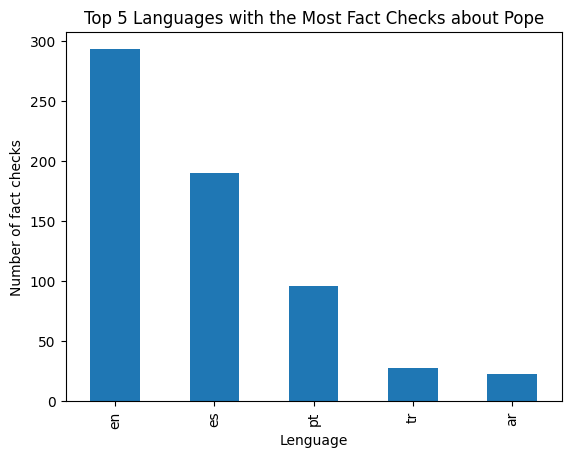

In [17]:
import matplotlib.pyplot as plt

df['Language'].value_counts().head(5).plot(kind='bar')

plt.title('Top 5 Languages with the Most Fact Checks about Pope')
plt.xlabel('Lenguage')
plt.ylabel('Number of fact checks')
plt.show()

# 3. Years with the highest number of lies about the Pope

As datas estão incluindo o dia de publicação, mas quero usar apenas o ano.

In [18]:
#Interestingly, the day with the highest number of fact-checks published about the Pope in the history of data collection, 
#was three days after Francisco's death.

df['Review Publication Date'].value_counts().head(5)

Review Publication Date
2025-04-24T00:00:00Z    17
2023-03-27T00:00:00Z    13
2025-04-30T00:00:00Z    11
2025-05-09T00:00:00Z     8
2025-04-25T00:00:00Z     8
Name: count, dtype: int64

_Note: The Google Fact Check tool only appeared in 2018, so it's really strange that there are publications before that date. But from what I've found, looking at the links in the table, they're from the Snopes agency, which does have texts before 2005 with fact checks. The texts were recently updated on the site, so I believe the data was imported._

In [19]:
#Counting the years with the most fact-checks
df['Review Publication Date'] = pd.to_datetime(df['Review Publication Date'])
df['Year'] = df['Review Publication Date'].dt.year
fact_checks_year = df['Year'].value_counts().sort_index(ascending=False)
fact_checks_year

Year
2025.0    304
2024.0     61
2023.0    138
2022.0     42
2021.0     68
2020.0     52
2019.0     11
2018.0     27
2017.0      7
2016.0      6
2015.0     10
2014.0      1
2006.0      1
2005.0      2
Name: count, dtype: int64

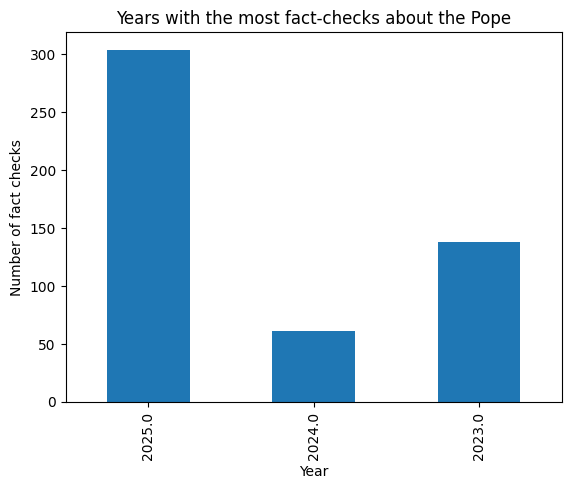

In [33]:
fact_checks_year.head(3).plot(kind='bar')
plt.title('Years with the most fact-checks about the Pope')
plt.xlabel('Year')
plt.ylabel('Number of fact checks')
plt.show()

In [22]:
#I created a filter by month to understand the behavior of the first six months of 2025
df_2025 = df[df['Review Publication Date'].dt.year == 2025]
df_2025['Month'] = df_2025['Review Publication Date'].dt.month
fact_checks_month = df_2025['Month'].value_counts().sort_index()
fact_checks_month

C:\Users\gf120867\AppData\Local\Temp\ipykernel_20692\1272392979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025['Month'] = df_2025['Review Publication Date'].dt.month


Month
1      4
2     18
3      9
4    134
5    126
6     13
Name: count, dtype: int64

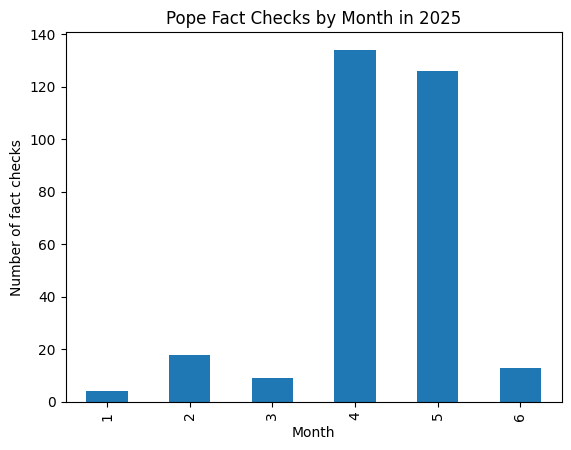

In [24]:
fact_checks_month.plot(kind='bar')
plt.title('Pope Fact Checks by Month in 2025')
plt.xlabel('Month')
plt.ylabel('Number of fact checks')
plt.show()

# Counting occurrences between Popes Francis and Leo XIV

It is important to note that in some cases the Popes may have been mentioned only as 'Pope,' without the name included, which affects the comparison.

In [42]:
#Counting occurrences between Popes Francis and Leo XIV
claims_eng = pd.read_excel("claims_traduzidas.xlsx")

pope_count = claims_eng['claim_en'].str.contains('Pope', case=False, na=False).sum()

leo_count = claims_eng['claim_en'].str.contains('Leo XIV', case=False, na=False).sum()

# Contando ocorrências de 'Francisco'
francis_count = claims_eng['claim_en'].str.contains('Francis', case=False, na=False).sum()

print(f"Leo XIV: {leao_count}")
print(f"Francis: {francisco_count}")
print(f"Pope: {pope_count}")

Leo XIV: 80
Francis: 411
Pope: 756


# Fact-checking agencies with the most publications about the Pope

It's important to be aware that not all fact-checking agencies in the world use Google's fact-checking tool.

In [52]:
df = pd.read_excel('factcheck_pope_results.xlsx')
df['Source Name'].value_counts()

Source Name
Snopes              72
AFP Fact Check      40
Newtral             36
Lead Stories        32
AFP Factual         30
                    ..
台灣事實查核中心             1
Fact Crescendo       1
Pagella Politica     1
FactRakers           1
AFP Fakty            1
Name: count, Length: 110, dtype: int64

In [27]:
count_agencies = df['Source Name'].nunique()
count_agencies

110

In [53]:
df['Source Name'].value_counts().head(5)

Source Name
Snopes            72
AFP Fact Check    40
Newtral           36
Lead Stories      32
AFP Factual       30
Name: count, dtype: int64

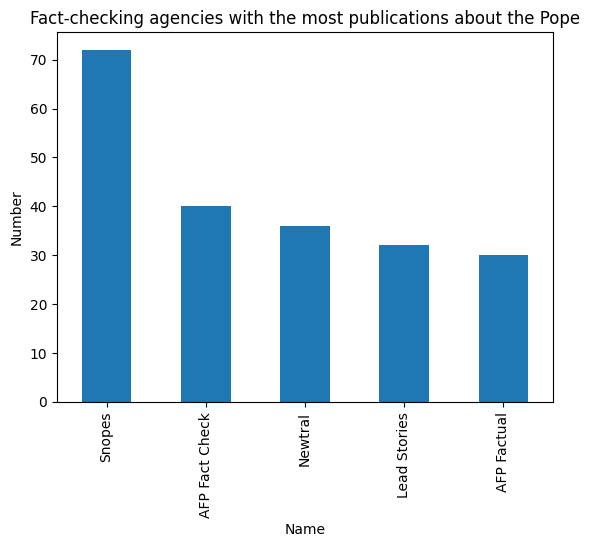

In [59]:
df['Source Name'].value_counts().head(5).plot(kind='bar')
plt.title('Fact-checking agencies with the most publications about the Pope')
plt.xlabel('Name')
plt.ylabel('Number')
plt.show()